In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

/opt/conda/envs/anaconda-ai-2025.12-py312/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
pip install xgboost catboost lightgbm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [3]:
Training = pd.read_csv("Test_data.csv")

In [4]:
Training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [5]:
Training.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [6]:
rename_map = {
    "KPIs_met >80%": "kpis_met_80",
    "awards_won?": "awards_won"}

Training = Training.rename(columns=rename_map)

In [7]:
Training.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_80', 'awards_won', 'avg_training_score'],
      dtype='object')

In [8]:
Training.duplicated().sum()

0

In [9]:
#Dataset Description
#The dataset contains historical employee information with the following key attributes:
#avg_training_score
#previous_year_rating
#kpis_met_80
#awards_won
#length_of_service
#no_of_trainings

In [10]:
Training["Performance_Score"] = (
    Training["kpis_met_80"] * 0.30 +
    Training["previous_year_rating"] * 0.25 +
    Training["avg_training_score"] * 0.20 +
    Training["awards_won"] * 0.10 +
    Training["no_of_trainings"] * 0.10 +
    Training["length_of_service"] * 0.05)

In [11]:
Training['Performance_Score'].head()

0      NaN
1    11.30
2     9.95
3    14.25
4    13.65
Name: Performance_Score, dtype: float64

In [12]:
Training['Performance_Score'].tail()

23485    13.1
23486    16.0
23487    11.3
23488     NaN
23489    19.9
Name: Performance_Score, dtype: float64

In [13]:
def performance_rating(score):
    if score >= 16.5:
        return "High"
    elif score >= 12.1:
        return "Medium"
    else:
        return "Low"

Training["Performance_Rating"] = Training["Performance_Score"].apply(performance_rating)

In [14]:
#Target Variable
#Performance_Target (multiclass):
#0 → Low Performer
#1 → Medium Performer
#2 → High Performer

In [15]:
Training["Performance_Rating"] = (
    Training["Performance_Rating"]
    .str.strip()
    .str.title()
)

Training["Performance_Target"] = Training["Performance_Rating"].map({
    "Low": 0,
    "Medium": 1,
    "High": 2
})

# Safety check
print(Training["Performance_Target"].isna().sum())

0


In [16]:
Training["Performance_Rating"].value_counts()
Training["Performance_Target"].value_counts(normalize=True)

Performance_Target
1    0.408344
0    0.368157
2    0.223499
Name: proportion, dtype: float64

/tmp/ipykernel_1881/1746742108.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


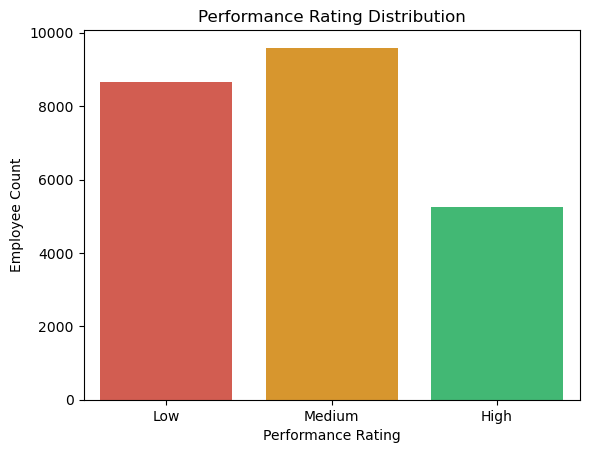

In [17]:
sns.countplot(
    x="Performance_Rating",
    data=Training,
    palette={
        "High": "#2ecc71",     # Green
        "Medium": "#f39c12",   # Orange
        "Low": "#e74c3c"       # Red
            })

plt.title("Performance Rating Distribution")
plt.xlabel("Performance Rating")
plt.ylabel("Employee Count")
plt.show()

In [18]:
Training["department"].dtype
Training["department"].unique()

array(['Technology', 'HR', 'Sales & Marketing', 'Procurement', 'Finance',
       'Analytics', 'Operations', 'Legal', 'R&D'], dtype=object)

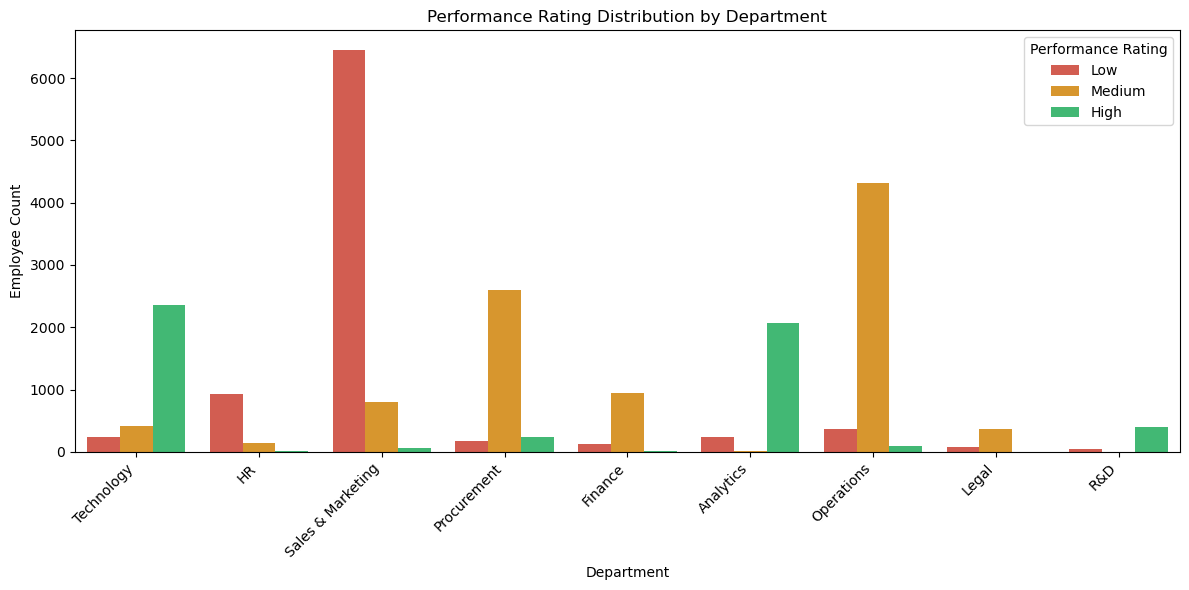

In [19]:
rating_map = {0: "Low", 1: "Medium", 2: "High"}
Training["Performance_Rating_Label"] = Training["Performance_Target"].map(rating_map)

plt.figure(figsize=(12, 6))

sns.countplot(
    x="department",
    hue="Performance_Rating_Label",
    data=Training,
    hue_order=["Low", "Medium", "High"],
    palette={
        "High": "#2ecc71",
        "Medium": "#f39c12",
        "Low": "#e74c3c"
    }
)

plt.title("Performance Rating Distribution by Department")
plt.xlabel("Department")
plt.ylabel("Employee Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Performance Rating")
plt.tight_layout()
plt.show()



In [20]:
Training["Performance_Rating"].isna().sum()

0

In [21]:
Training.groupby('education')['Performance_Score'].mean().sort_values(ascending=False)

education
Below Secondary     14.298190
Master's & above    14.256290
Bachelor's          13.986416
Name: Performance_Score, dtype: float64

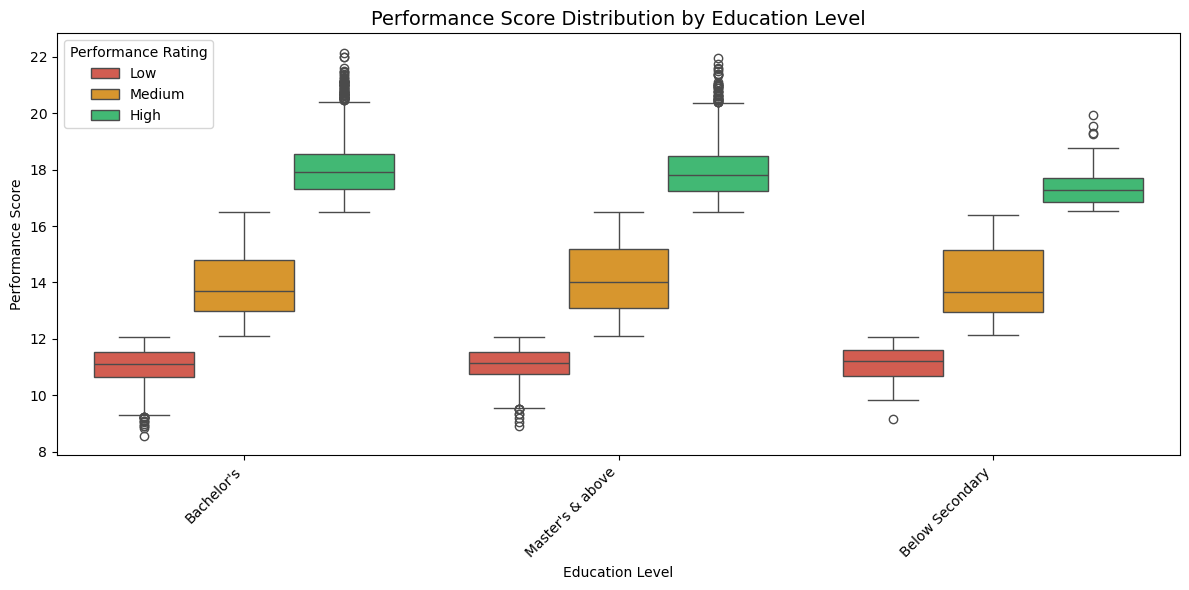

In [22]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    x="education",
    y="Performance_Score",
    hue="Performance_Rating",
    data=Training,
    palette={
        "High": "#2ecc71",     # Green
        "Medium": "#f39c12",   # Orange
        "Low": "#e74c3c"       # Red
    }
)

plt.title("Performance Score Distribution by Education Level", fontsize=14)
plt.xlabel("Education Level")
plt.ylabel("Performance Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Performance Rating")
plt.tight_layout()
plt.show()

In [23]:
Training['gender'].value_counts().reset_index()

,gender,count
0,m,16596
1,f,6894


In [24]:
Training['Performance_Rating'].value_counts().reset_index()

,Performance_Rating,count
0,Medium,9592
1,Low,8648
2,High,5250


In [25]:
Training.groupby(["department","Performance_Rating"])["kpis_met_80"].mean().reset_index()

,department,Performance_Rating,kpis_met_80
0,Analytics,High,0.404050
1,Analytics,Low,0.417021
2,Analytics,Medium,0.100000
3,Finance,High,0.647059
4,Finance,Low,0.353846
5,Finance,Medium,0.398305
6,HR,High,0.833333
7,HR,Low,0.311087
8,HR,Medium,0.555556
9,Legal,High,0.000000


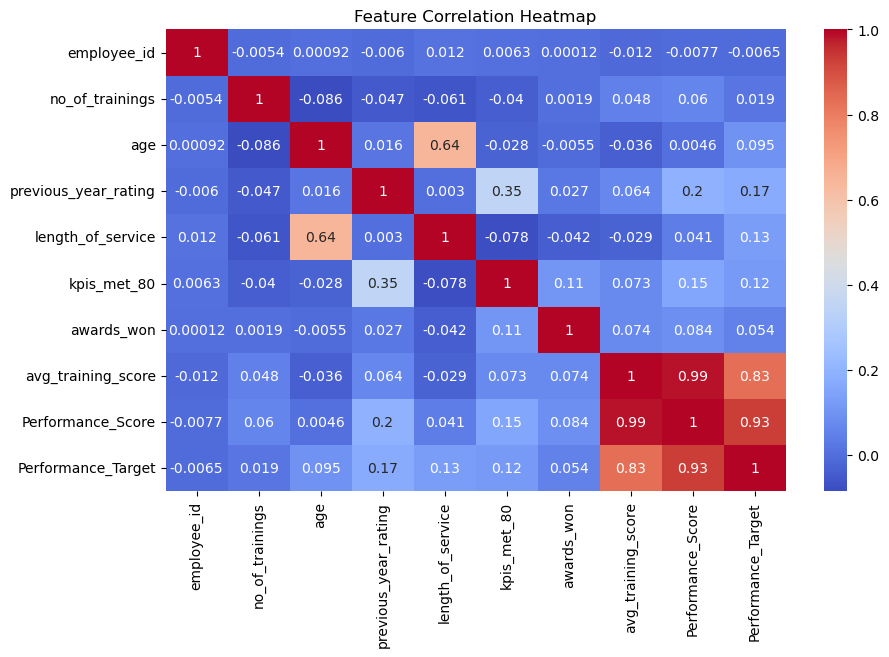

In [26]:
num_cols = Training.select_dtypes(include='number')
plt.figure(figsize=(10,6))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
#Model Building
cat_cols = Training.select_dtypes(include="object").columns
le = LabelEncoder()

for col in cat_cols:
    Training[col] = le.fit_transform(Training[col])

In [28]:
X = Training[
    [   "avg_training_score",
        "previous_year_rating",
        "kpis_met_80",
        "awards_won"]
]
y = Training["Performance_Target"]

In [29]:
#Handling Missing Values
X = X.fillna(X.median())
y = y.fillna(y.mode()[0])

In [31]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [32]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}

In [34]:
# Model Selection Rationale
#Tree-based ensemble models were selected because:
#They handle non-linear relationships well
#They do not require feature scaling
#They provide feature importance for business interpretation
#Models used:
#XGBoost
#CatBoost
#LightGBM

In [35]:
models = {
    "XGBoost": XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        eval_metric="logloss",
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        verbose=0,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        random_state=42
    )
}

In [36]:
models

{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=150, n_jobs=None,
               num_parallel_tree=None, ...),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x7575f3e5ae40>,
 'LightGBM': LGBMClassifier(random_state=42)}

In [37]:
def apply_scaler(scaler, X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [38]:
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Confusion_Matrix": cm
    })

    print(f"\nModel: {model_name}")
    print("Accuracy:", round(acc, 4))
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred))


Model: XGBoost
Accuracy: 0.9261
Confusion Matrix:
 [[1468  167   95]
 [  45 1849   24]
 [   0   16 1034]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1730
           1       0.91      0.96      0.94      1918
           2       0.90      0.98      0.94      1050

    accuracy                           0.93      4698
   macro avg       0.93      0.93      0.93      4698
weighted avg       0.93      0.93      0.93      4698


Model: CatBoost
Accuracy: 0.9291
Confusion Matrix:
 [[1486  151   93]
 [  47 1853   18]
 [   2   22 1026]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1730
           1       0.91      0.97      0.94      1918
           2       0.90      0.98      0.94      1050

    accuracy                           0.93      4698
   macro avg       0.93      0.93      0.93      4698
weighted avg       0.93      0.93      0.93      4698

[LightGBM] [Info] Auto-

/opt/conda/envs/anaconda-ai-2025.12-py312/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-ai-2025.12-py312/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Model: LightGBM
Accuracy: 0.9306
Confusion Matrix:
 [[1493  144   93]
 [  47 1853   18]
 [   2   22 1026]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1730
           1       0.92      0.97      0.94      1918
           2       0.90      0.98      0.94      1050

    accuracy                           0.93      4698
   macro avg       0.93      0.94      0.93      4698
weighted avg       0.93      0.93      0.93      4698



In [39]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df

,Model,Accuracy,Confusion_Matrix
2,LightGBM,0.9306,"[[1493, 144, 93], [47, 1853, 18], [2, 22, 1026]]"
1,CatBoost,0.9291,"[[1486, 151, 93], [47, 1853, 18], [2, 22, 1026]]"
0,XGBoost,0.9261,"[[1468, 167, 95], [45, 1849, 24], [0, 16, 1034]]"


In [40]:
best_model = results_df.iloc[0]['Model']
best_model

'LightGBM'

In [41]:
best_xgb = models['XGBoost']
best_xgb.fit(X_train, y_train)

import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,Feature,Importance
0,avg_training_score,0.861058
1,previous_year_rating,0.099087
2,kpis_met_80,0.034602
3,awards_won,0.005254


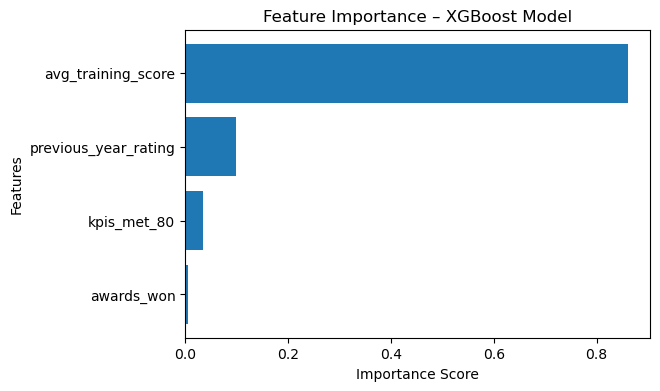

In [42]:
plt.figure(figsize=(6,4))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance – XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

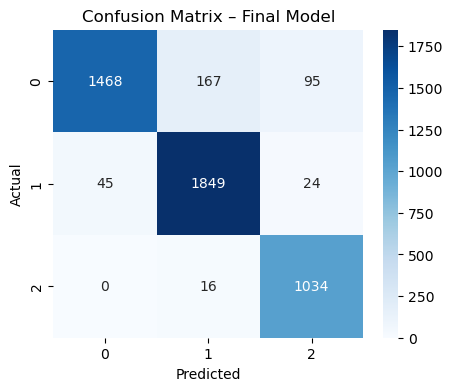

In [43]:
import seaborn as sns

cm = confusion_matrix(y_test, best_xgb.predict(X_test))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
#After correcting the preprocessing pipeline and removing unnecessary feature scaling,the tree-based models achieved stable accuracy around 93%. 
#These results are realistic,generalizable, and align with best practices for ensemble learning methods.